In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
aer_sim = Aer.get_backend('aer_simulator')

In [3]:
def get_noise(p_meas,p_gate):
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

In [4]:
noise_model = get_noise(0.01,0.01)

ibmqfactory.load_account:WARNING:2022-08-03 19:52:13,802: Credentials are already in use. The existing account in the session will be replaced.


Circuit construction took 0.003748023000298417 sec.
                                                                          »
q161_0: ──────────────────────────────────────────────────────────────────»
           ┌───┐    ┌──────────┐                                          »
q161_1: ───┤ H ├────┤ Rz(3π/2) ├──────────────────────────────────────────»
           ├───┤    ├──────────┤                                          »
q161_2: ───┤ H ├────┤ Rz(3π/4) ├────■─────────■──────────■─────────■──────»
        ┌──┴───┴───┐└──────────┘┌───┴───┐┌────┴─────┐┌───┴───┐┌────┴─────┐»
q161_3: ┤ Ry(-π/2) ├────────────┤ Rz(0) ├┤ Rx(-π/8) ├┤ Rz(0) ├┤ Rx(-π/8) ├»
        └──────────┘            └───────┘└──────────┘└───────┘└──────────┘»
  c6: 4/══════════════════════════════════════════════════════════════════»
                                                                          »
«                                                                       »
«q161_0: ─────────────────────────────

/tmp/ipykernel_595/2580300789.py:138: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  active_qubits[qubit.index] = True


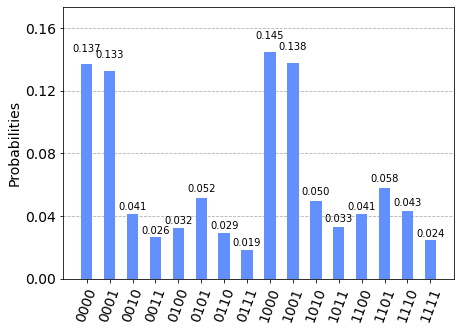

In [11]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
import numpy as np
from qiskit.circuit.library.standard_gates import SGate, SdgGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import Aer
from qiskit.compiler import transpile
from time import perf_counter
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ



#generalized form of allowable: Matrix
#theta = 0 to 2*pi
#matrix = np.array([1+(np.cos(theta))**2, -np.sin(2*theta)/2],[-np.sin(2*theta)/2, 1+(np.sin(theta))**2])

"""#example 1
theta = (3*np.pi)/2

matrix = np.array([1+(np.cos(theta))**2, -np.sin(2*theta)/2],[-np.sin(2*theta)/2, 1+(np.sin(theta))**2])
sol = np.array([1,0])"""

#example 2
matrix = np.array([[1.5, 0.5],[0.5, 1.5]])
sol = np.array([1,-1])

k = np.sqrt((sol[0]**2)+(sol[1]**2)) #scaling factor so solution has mag. 1
sol = sol*(1/k)

#t = number of variables + log(2+1/(2*error)) //some magic number
t = np.pi/2 #changed to pi/2

#r = number that increases precision of solution as it gets higher, but requires more computation
r = 4

#number of shots
s=10000

#controlled rotation
rot_number = 2

qubits = QuantumRegister(4)
measurement = ClassicalRegister(4)
circuit = QuantumCircuit(qubits,measurement)

#last index of qubits
last_index = len(qubits)-1

csdg = SdgGate().control(1) #create a controlled adjoint S gate


start = perf_counter()

#load sol
circuit.ry(2*np.arctan2(sol[1],sol[0]),qubits[-1])


#phase estimation

#set superposition
circuit.h(qubits[1])
circuit.h(qubits[2])

#trotterization
beta = matrix[0][1]
gamma = (matrix[0][0]-matrix[1][1])/2.0
alpha = (matrix[0][0]+matrix[1][1])/2.0 #added alpha

for i in (range(1,last_index)):
    circuit.rz(t*alpha*2**(i-1),  qubits[last_index-i])
    for x in range(r):
        circuit.crz(((-2*t*gamma*2**(i-1))/r),qubits[last_index-i],qubits[-1])
        circuit.crx(((-2*t*beta*2**(i-1))/r),qubits[last_index-i],qubits[-1])


circuit.swap(qubits[1],qubits[2])
circuit.h(qubits[2])

circuit.append(csdg,[1,2])


circuit.h(qubits[1])
circuit.swap(qubits[1],qubits[2])


#controlled rotation
circuit.cry((2*np.pi)/(2**rot_number),qubits[1],qubits[0])
circuit.cry((np.pi)/(2**rot_number),qubits[2],qubits[0])


# #inverse phase estimation

circuit.swap(qubits[1],qubits[2])
circuit.h(qubits[1])

cs = SGate().control(1) #create a controlled S gate
circuit.append(cs,[1,2])

circuit.h(qubits[2])
circuit.swap(qubits[1],qubits[2])

# #reverse trotterization
for i in reversed(range(1,last_index)):
    circuit.rz(-t*alpha*2**(i-1),  qubits[last_index-i]) #added by Nikita
    for x in range(r):
        circuit.crx(((2*t*beta*2**(i-1))/r),qubits[last_index-i],qubits[-1])
        circuit.crz(((2*t*gamma*2**(i-1))/r),qubits[last_index-i],qubits[-1])
        
        
# #undo superposition
circuit.h(qubits[1])
circuit.h(qubits[2])

    
circuit.measure(qubits,measurement)
end = perf_counter()
print(f"Circuit construction took {(end - start)} sec.")
print(circuit)

# Transpile the circuit to something that can run on the Ozlo machine
provider = IBMQ.load_account()
machine = "ibmq_manila"
backend = provider.get_backend(machine)

print(f"Transpiling for {machine}...")
start = perf_counter()
circuit = transpile(circuit, backend=backend, optimization_level=1)
end = perf_counter()
print(f"Compiling and optimizing took {(end - start)} sec.")
print(circuit)

# Get the number of qubits needed to run the circuit
active_qubits = {}
for op in circuit.data:
    if op[0].name != "barrier" and op[0].name != "snapshot":
        for qubit in op[1]:
                active_qubits[qubit.index] = True

print(f"Width: {len(active_qubits)} qubits")

# Get some other metrics
print(f"Depth: {circuit.depth()}")
print(f"Gate counts: {circuit.count_ops()}")

qobj = assemble(circuit)
counts = aer_sim.run(qobj, noise_model=noise_model).result().get_counts()

plot_histogram(counts)